<a href="https://colab.research.google.com/github/kridtapon/Demand-Driven-KST-Strategy/blob/main/Demand_Driven_KST_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.5/527.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.2 MB/s eta 0:00:00


In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate the KST (Know Sure Thing) and Signal line
def calculate_kst(df, short_period=10, long_period=15, roc_short_period=5, roc_long_period=10):
    """
    Calculate KST (Know Sure Thing) and its Signal line.
    """
    # Rate of Change (ROC) for short and long periods
    roc_short = df['Close'].pct_change(periods=short_period) * 100
    roc_long = df['Close'].pct_change(periods=long_period) * 100
    roc_mid = df['Close'].pct_change(periods=roc_short_period) * 100
    roc_longer = df['Close'].pct_change(periods=roc_long_period) * 100

    # Smoothed ROC using weighted moving averages
    wma_short = roc_short.rolling(window=short_period).mean()
    wma_long = roc_long.rolling(window=long_period).mean()
    wma_mid = roc_mid.rolling(window=roc_short_period).mean()
    wma_longer = roc_longer.rolling(window=roc_long_period).mean()

    # KST = weighted sum of ROCs
    kst = (wma_short * 1) + (wma_long * 2) + (wma_mid * 3) + (wma_longer * 4)

    # Signal line: EMA of KST
    kst_signal = kst.ewm(span=9).mean()

    return kst, kst_signal

# Function to calculate the Demarker Indicator
def calculate_demarker(df, period=14):
    """
    Calculate the Demarker Indicator.
    """
    # Calculate the DeMarker Indicator
    dm_plus = np.maximum(df['High'].shift(1) - df['High'], 0)
    dm_minus = np.maximum(df['Low'] - df['Low'].shift(1), 0)

    # Calculate the smoothed values
    dem_plus = dm_plus.rolling(window=period).sum()
    dem_minus = dm_minus.rolling(window=period).sum()

    # Demarker Indicator
    dem = dem_plus / (dem_plus + dem_minus)

    return dem

# Define the stock symbol and time period
symbol = 'META'  #
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate KST and its Signal line
df['KST'], df['KST_Signal'] = calculate_kst(df)

# Calculate the Demarker Indicator
df['Demarker'] = calculate_demarker(df)

# Define Entry and Exit signals based on KST and Demarker Indicator
df['Entry'] = (df['KST'] > df['KST_Signal']) & (df['Demarker'] < 0.3)
df['Exit'] = (df['KST'] < df['KST_Signal']) & (df['Demarker'] > 0.7)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           384010.225574
Total Return [%]                       284.010226
Benchmark Return [%]                   180.172876
Max Gross Exposure [%]                      100.0
Total Fees Paid                       5260.511293
Max Drawdown [%]                        32.529187
Max Drawdown Duration                       402.0
Total Trades                                   13
Total Closed Trades                            12
Total Open Trades                               1
Open Trade PnL                      -25172.099388
Win Rate [%]                            58.333333
Best Trade [%]                           53.02542
Worst Trade [%]                        -14.385725
Avg Winning Trade [%]                   31.210987
Avg Losing Trade [%]                    -7.563247


In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import plotly.subplots as sp

# Function to calculate the KST (Know Sure Thing) and Signal line
def calculate_kst(df, short_period=10, long_period=15, roc_short_period=5, roc_long_period=10):
    """
    Calculate KST (Know Sure Thing) and its Signal line.
    """
    # Rate of Change (ROC) for short and long periods
    roc_short = df['Close'].pct_change(periods=short_period) * 100
    roc_long = df['Close'].pct_change(periods=long_period) * 100
    roc_mid = df['Close'].pct_change(periods=roc_short_period) * 100
    roc_longer = df['Close'].pct_change(periods=roc_long_period) * 100

    # Smoothed ROC using weighted moving averages
    wma_short = roc_short.rolling(window=short_period).mean()
    wma_long = roc_long.rolling(window=long_period).mean()
    wma_mid = roc_mid.rolling(window=roc_short_period).mean()
    wma_longer = roc_longer.rolling(window=roc_long_period).mean()

    # KST = weighted sum of ROCs
    kst = (wma_short * 1) + (wma_long * 2) + (wma_mid * 3) + (wma_longer * 4)

    # Signal line: EMA of KST
    kst_signal = kst.ewm(span=9).mean()

    return kst, kst_signal

# Function to calculate the Demarker Indicator
def calculate_demarker(df, period=14):
    """
    Calculate the Demarker Indicator.
    """
    # Calculate the DeMarker Indicator
    dm_plus = np.maximum(df['High'].shift(1) - df['High'], 0)
    dm_minus = np.maximum(df['Low'] - df['Low'].shift(1), 0)

    # Calculate the smoothed values
    dem_plus = dm_plus.rolling(window=period).sum()
    dem_minus = dm_minus.rolling(window=period).sum()

    # Demarker Indicator
    dem = dem_plus / (dem_plus + dem_minus)

    return dem

# Define the stock symbol and time period
symbol = 'META'  # You can change this to any stock symbol
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate KST and its Signal line
df['KST'], df['KST_Signal'] = calculate_kst(df)

# Calculate the Demarker Indicator
df['Demarker'] = calculate_demarker(df)

# Create a figure with subplots (1 row, 2 columns)
fig = sp.make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=("Candlestick Chart", "KST & Demarker Indicator"),
    row_heights=[0.7, 0.3]
)

# Candlestick chart
candlestick = go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candlesticks'
)

# KST and Signal line plot
kst_trace = go.Scatter(
    x=df.index,
    y=df['KST'],
    mode='lines',
    name='KST',
    line=dict(color='blue')
)

kst_signal_trace = go.Scatter(
    x=df.index,
    y=df['KST_Signal'],
    mode='lines',
    name='KST Signal',
    line=dict(color='orange', dash='dash')
)

# Demarker Indicator plot
demarker_trace = go.Scatter(
    x=df.index,
    y=df['Demarker'],
    mode='lines',
    name='Demarker',
    line=dict(color='green')
)

# Add traces to the figure
fig.add_trace(candlestick, row=1, col=1)
fig.add_trace(kst_trace, row=2, col=1)
fig.add_trace(kst_signal_trace, row=2, col=1)
fig.add_trace(demarker_trace, row=2, col=1)

# Update layout settings
fig.update_layout(
    title=f'{symbol} Candlestick with KST & Demarker Indicator',
    xaxis_title='Date',
    yaxis_title='Price',
    yaxis2_title='Indicator Value',
    showlegend=True,
    template="plotly_dark"
)

# Show the plot
fig.show()


[*********************100%***********************]  1 of 1 completed


In [5]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.0 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/mplfinance/_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




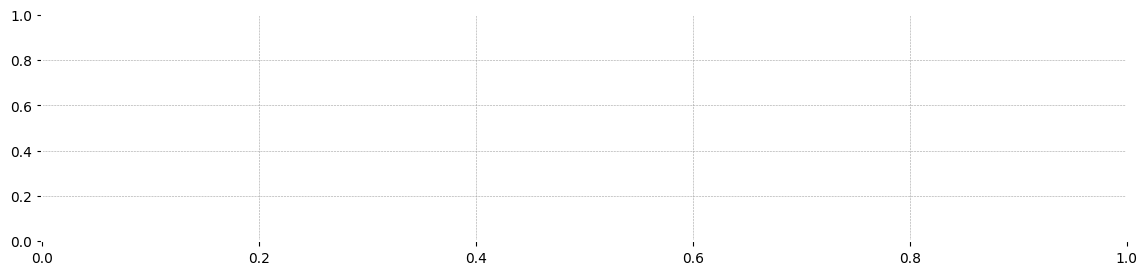

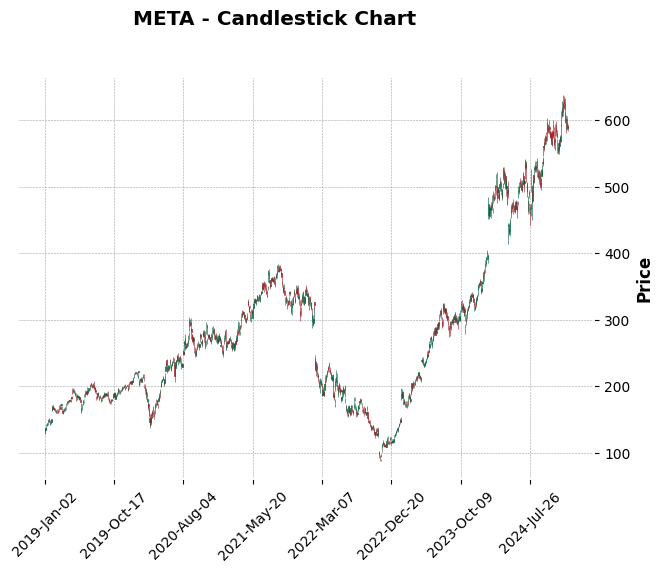

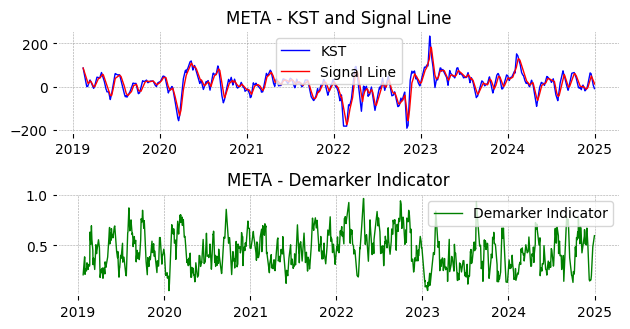

In [12]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

# Function to calculate the KST (Know Sure Thing) and Signal line
def calculate_kst(df, short_period=10, long_period=15, roc_short_period=5, roc_long_period=10):
    """
    Calculate KST (Know Sure Thing) and its Signal line.
    """
    # Rate of Change (ROC) for short and long periods
    roc_short = df['Close'].pct_change(periods=short_period) * 100
    roc_long = df['Close'].pct_change(periods=long_period) * 100
    roc_mid = df['Close'].pct_change(periods=roc_short_period) * 100
    roc_longer = df['Close'].pct_change(periods=roc_long_period) * 100

    # Smoothed ROC using weighted moving averages
    wma_short = roc_short.rolling(window=short_period).mean()
    wma_long = roc_long.rolling(window=long_period).mean()
    wma_mid = roc_mid.rolling(window=roc_short_period).mean()
    wma_longer = roc_longer.rolling(window=roc_long_period).mean()

    # KST = weighted sum of ROCs
    kst = (wma_short * 1) + (wma_long * 2) + (wma_mid * 3) + (wma_longer * 4)

    # Signal line: EMA of KST
    kst_signal = kst.ewm(span=9).mean()

    return kst, kst_signal

# Function to calculate the Demarker Indicator
def calculate_demarker(df, period=14):
    """
    Calculate the Demarker Indicator.
    """
    # Calculate the DeMarker Indicator
    dm_plus = np.maximum(df['High'].shift(1) - df['High'], 0)
    dm_minus = np.maximum(df['Low'] - df['Low'].shift(1), 0)

    # Calculate the smoothed values
    dem_plus = dm_plus.rolling(window=period).sum()
    dem_minus = dm_minus.rolling(window=period).sum()

    # Demarker Indicator
    dem = dem_plus / (dem_plus + dem_minus)

    return dem

# Define the stock symbol and time period
symbol = 'META'  #
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate KST and Signal line
kst, kst_signal = calculate_kst(df)

# Calculate Demarker Indicator
dem = calculate_demarker(df)

# Plotting
plt.figure(figsize=(14, 10))

# Subplot 1: Candlestick Chart
plt.subplot(3, 1, 1)
mpf.plot(df, type='candlestick', style='charles', title=f'{symbol} - Candlestick Chart', ylabel='Price')

# Subplot 2: KST and Signal Line
plt.subplot(3, 1, 2)
plt.plot(df.index, kst, label='KST', color='blue', lw=1)
plt.plot(df.index, kst_signal, label='Signal Line', color='red', lw=1)
plt.title(f'{symbol} - KST and Signal Line')
plt.legend()

# Subplot 3: Demarker Indicator
plt.subplot(3, 1, 3)
plt.plot(df.index, dem, label='Demarker Indicator', color='green', lw=1)
plt.title(f'{symbol} - Demarker Indicator')
plt.legend()

plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


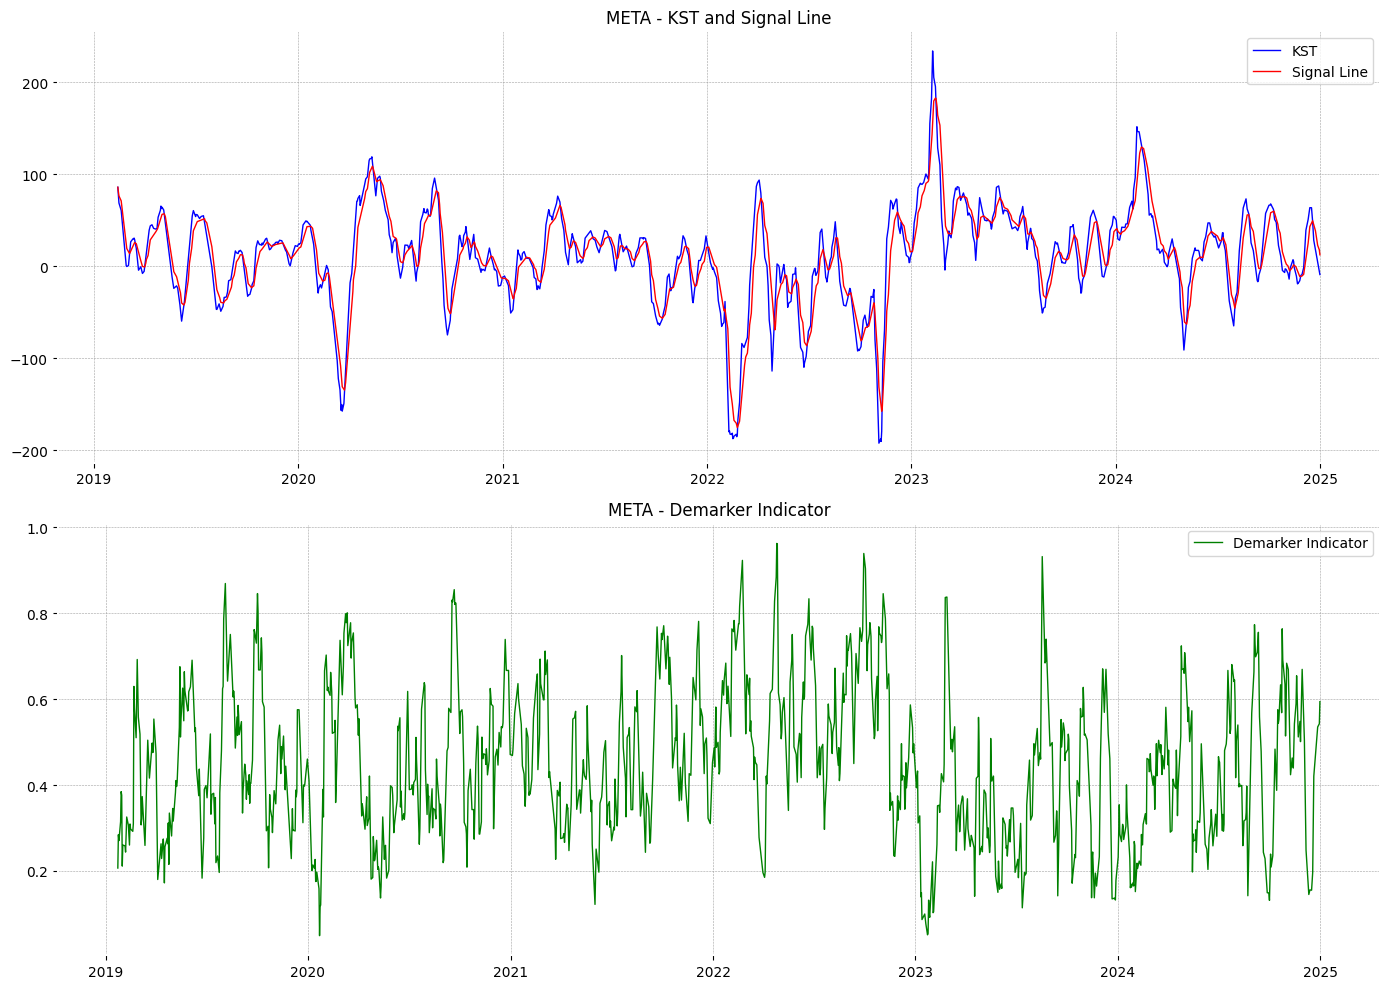

In [13]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the KST (Know Sure Thing) and Signal line
def calculate_kst(df, short_period=10, long_period=15, roc_short_period=5, roc_long_period=10):
    """
    Calculate KST (Know Sure Thing) and its Signal line.
    """
    # Rate of Change (ROC) for short and long periods
    roc_short = df['Close'].pct_change(periods=short_period) * 100
    roc_long = df['Close'].pct_change(periods=long_period) * 100
    roc_mid = df['Close'].pct_change(periods=roc_short_period) * 100
    roc_longer = df['Close'].pct_change(periods=roc_long_period) * 100

    # Smoothed ROC using weighted moving averages
    wma_short = roc_short.rolling(window=short_period).mean()
    wma_long = roc_long.rolling(window=long_period).mean()
    wma_mid = roc_mid.rolling(window=roc_short_period).mean()
    wma_longer = roc_longer.rolling(window=roc_long_period).mean()

    # KST = weighted sum of ROCs
    kst = (wma_short * 1) + (wma_long * 2) + (wma_mid * 3) + (wma_longer * 4)

    # Signal line: EMA of KST
    kst_signal = kst.ewm(span=9).mean()

    return kst, kst_signal

# Function to calculate the Demarker Indicator
def calculate_demarker(df, period=14):
    """
    Calculate the Demarker Indicator.
    """
    # Calculate the DeMarker Indicator
    dm_plus = np.maximum(df['High'].shift(1) - df['High'], 0)
    dm_minus = np.maximum(df['Low'] - df['Low'].shift(1), 0)

    # Calculate the smoothed values
    dem_plus = dm_plus.rolling(window=period).sum()
    dem_minus = dm_minus.rolling(window=period).sum()

    # Demarker Indicator
    dem = dem_plus / (dem_plus + dem_minus)

    return dem

# Define the stock symbol and time period
symbol = 'META'  #
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate KST and Signal line
kst, kst_signal = calculate_kst(df)

# Calculate Demarker Indicator
dem = calculate_demarker(df)

# Plotting
plt.figure(figsize=(14, 10))

# Subplot 1: KST and Signal Line
plt.subplot(2, 1, 1)
plt.plot(df.index, kst, label='KST', color='blue', lw=1)
plt.plot(df.index, kst_signal, label='Signal Line', color='red', lw=1)
plt.title(f'{symbol} - KST and Signal Line')
plt.legend()

# Subplot 2: Demarker Indicator
plt.subplot(2, 1, 2)
plt.plot(df.index, dem, label='Demarker Indicator', color='green', lw=1)
plt.title(f'{symbol} - Demarker Indicator')
plt.legend()

plt.tight_layout()
plt.show()
